In [1]:
!pip install tifffile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster


In [4]:
############################################
## Functions

def scaleImgPerc(imgIn, percLow, percHigh):
    if len(imgIn.shape) == 2:
        imgIn = imgIn.reshape([imgIn.shape[0], imgIn.shape[1], 1])
        
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgIn, percLow, axis=0)
    ranges = np.percentile(imgIn, percHigh, axis=0) - mins
    imgIn = (imgIn - mins[None, :]) / ranges[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn


In [5]:
############################################
## Hard coded paths and vars
BDIR = '/content/drive/My Drive/CommonFiles/MUSA650-Data/Prj_DSTL'
LDIR = '/content/drive/My Drive/CommonFiles/MUSA650-Data/Prj_DSTL/Data_Init'
IMGDIR = '/content/drive/My Drive/CommonFiles/MUSA650-Data/Prj_DSTL/Data_Prep'

fSuff = '_allChannelsAndLabels.p'
csvClassNames = LDIR + '/DSTL_ClassTypes.csv'

selId = '6100_2_3'
xBounds = [0, 300]
yBounds = [0, 300]
selCh = 0
numCl = 5



In [6]:
############################################
## Main

## Read pickle file
dataFile = IMGDIR + '/' + selId + fSuff
dataMat = pickle.load(open(dataFile, "rb"))
dfC = pd.read_csv(csvClassNames)

In [7]:
dataMat.shape

(3348, 3391, 10)

In [8]:
### Using single channel
### Select crop area and channel
img = dataMat[xBounds[0]:xBounds[1], yBounds[0]:yBounds[1], selCh]
print (img.shape)

X = img.reshape((-1,1))

numCl = 3

k_means = cluster.KMeans(n_clusters=numCl)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)
X_cluster


(300, 300)


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 0, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int32)

In [9]:
X.shape

(90000, 1)

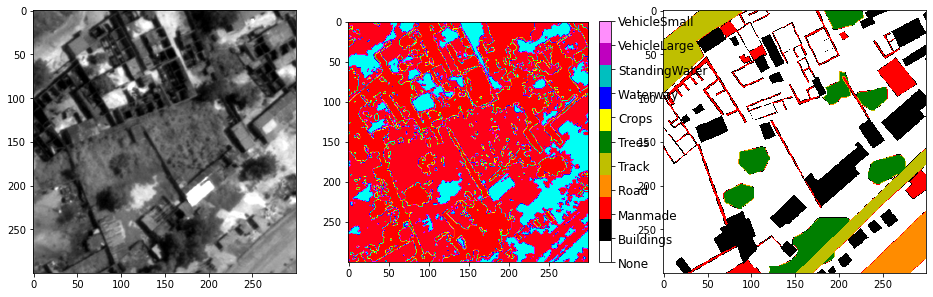

In [10]:
### View results
cmap = matplotlib.colors.ListedColormap(['w', 'k', 'r', '#FF8C00','y','g','#FFFF00','b','c','m','#FF8EFC']) #10 classes

imgMask = dataMat[:,:,9]
imgMask = imgMask[xBounds[0]:xBounds[1], yBounds[0]:yBounds[1]]
imgMask[0,0]=10
selLabels = np.unique(imgMask.flatten())

fig, ax = plt.subplots(1, 3, figsize=[16,16])
pImg = ax[0].imshow(scaleImgPerc(img, 1, 99).squeeze(), cmap='gray')
pMask = ax[1].imshow(X_cluster, cmap="hsv")
pMask = ax[2].imshow(imgMask, cmap=cmap)
cbar = fig.colorbar(pMask, ax=ax[1], fraction=0.046, pad=0.04, ticks=np.arange(0,11))
cbar.ax.set_yticklabels(dfC.Class.tolist())
cbar.ax.tick_params(labelsize=12)

plt.show()


In [11]:
### Using all channels
img = dataMat[xBounds[0]:xBounds[1], yBounds[0]:yBounds[1],0:10]
new_shape = (img.shape[0] * img.shape[1], img.shape[2]-1)
print (img.shape)

print (new_shape)

X = img[:, :, 0:9].reshape(new_shape)

print (X.shape)

k_means = cluster.KMeans(n_clusters=numCl)
k_means.fit(X)

X_cluster = k_means.labels_

X_cluster = X_cluster.reshape(img[:, :, 0].shape)

cmap = matplotlib.colors.ListedColormap(['w', 'k', 'r', '#FF8C00','y','g','#FFFF00','b','c','m','#FF8EFC']) #10 classes

imgMask = dataMat[:,:,9]
imgMask = imgMask[xBounds[0]:xBounds[1], yBounds[0]:yBounds[1]]
imgMask[0,0]=10
selLabels = np.unique(imgMask.flatten())


(300, 300, 10)
(90000, 9)
(90000, 9)


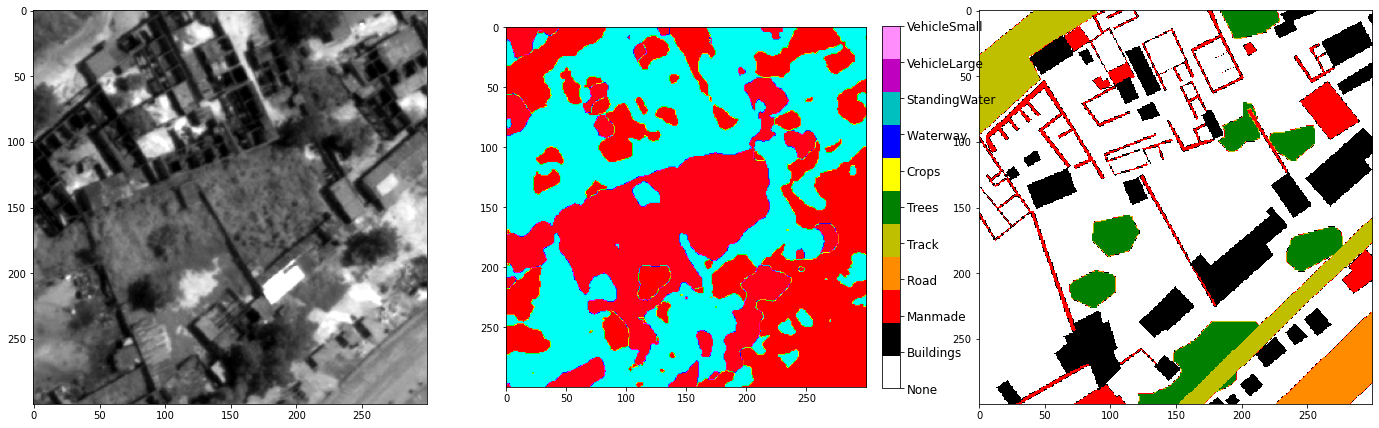

In [12]:
fig, ax = plt.subplots(1, 3, figsize=[24,24])
pImg = ax[0].imshow(scaleImgPerc(img, 1, 99)[:,:,0].squeeze(), cmap='gray')
pMask = ax[1].imshow(X_cluster, cmap="hsv")
pMask = ax[2].imshow(imgMask, cmap=cmap)
cbar = fig.colorbar(pMask, ax=ax[1], fraction=0.046, pad=0.04, ticks=np.arange(0,11))
cbar.ax.set_yticklabels(dfC.Class.tolist())
cbar.ax.tick_params(labelsize=12)

plt.show()
